In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import nltk #For POS tagging
import sklearn #For generating some matrices
import pandas as pd#For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #MAkes the plots look nice

import pickle #if you want to save layouts
import os

%matplotlib inline

D:\computation\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


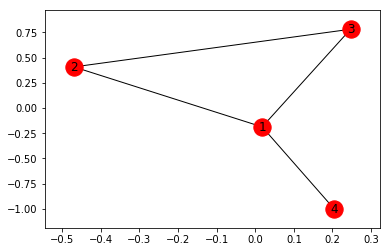

In [2]:
g = nx.Graph()

g.add_node(1)
g.add_node(2)
g.add_node(3)

g.add_edges_from([(1, 2), (2, 3), (3, 1), (1,4)])


g.edges[1, 2]['weight'] = 2
g.edges[1, 4]['weight'] = 2
g.edges[1, 4]

nx.draw_networkx(g)


In [3]:
import pandas
powMIA = pandas.read_csv('C:/Users/Alex/contentAnalysis/content-analysis-2018/data/powMIA.csv')

In [4]:
powMIA

,article,date,cluster
0,"Neil Sheehan interview with Tran Ngoc Chau,...",January 14 1980,0
1,Bill Kurtis article on plight of half-Ameri...,March 2 1980,0
2,Pakistan plans to close its embassy in Hano...,April 12 1980,0
3,Pakistan plans to close its embassy in Hano...,April 12 1980,0
4,"South Korean diplomats Rhee Dai Young, mini...",April 14 1980,0
5,"Vietnamese officials, who have established ...",April 14 1980,1
6,"Vietnamese officials, who have established ...",April 14 1980,1
7,South Korean Information Minister Lee Kyoo ...,April 20 1980,0
8,To the Editor: Since the fall of South Vi...,June 21 1980,0
9,WORLD NEWS BRIEFS; Racial Unrest to Be Cru...,June 23 1980,0


In [5]:
powMIA['tokenized_sents'] = powMIA['article'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
powMIA['normalized_sents'] = powMIA['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = None, stemmer = lucem_illud.stemmer_basic) for s in x])

In [6]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [75]:
g = wordCooccurrence(powMIA['normalized_sents'][:15].sum())

In [76]:
len(g.nodes)

1057

In [77]:
len(g.edges)

23535

In [78]:
def tokenize(text):
    tokenlist = nltk.word_tokenize(text)
    normalized = lucem_illud.normalizeTokens(tokenlist, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic)
    return normalized

In [79]:
powVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)

# let's see what happens when I take the range [:10] our of vects_incidence
# this is apparently a bad idea...

powVects_incidence = powVectorizer.fit_transform(powMIA['article'][:15])

In [80]:
powVects_incidence.shape

(15, 966)

In [81]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((powVectorizer.get_feature_names()[i] for i in range(powVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(powVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, powVectorizer.get_feature_names()[w], {'weight' : powVects_incidence[d, w]}) for d, w in zip(*powVects_incidence.nonzero())))

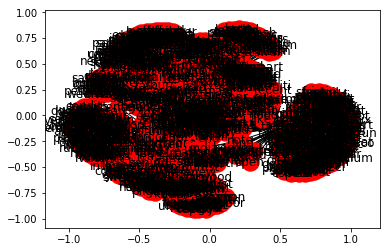

In [82]:
nx.draw_networkx(g_2mode)

In [83]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [84]:
gDoc = contractNetwork(g_2mode, 'doc')

In [85]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 15
Number of edges: 105
Average degree:  14.0000


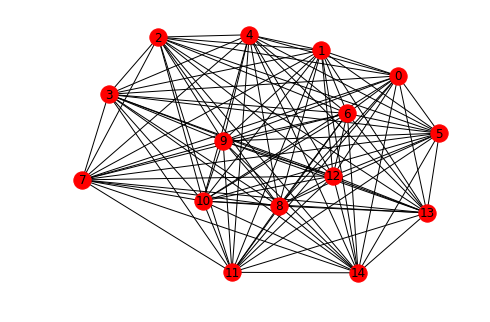

In [86]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

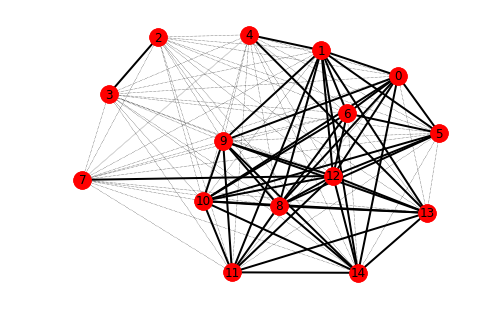

In [87]:

wMedian = np.median([d['weight'] for n1, n2, d in gDoc.edges(data = True)])
edgesHigh = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] > wMedian]
edgesLow = [(n1, n2) for n1, n2, d in gDoc.edges(data = True) if d['weight'] <= wMedian]
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}, edgelist = edgesLow, style='dotted', width=.5)
nx.draw(gDoc, pos = layout, nodelist=None, edgelist = edgesHigh, width=2)

In [88]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 966
Number of edges: 112256
Average degree: 232.4141


In [89]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.083505558722919

In [90]:
gWord.remove_edges_from([(n1, n2) for n1, n2, d in gWord.edges(data = True) if d['weight'] <= 1])
gWord.remove_nodes_from(list(nx.isolates(gWord))) #since we are changing the graph list() evuluates the isolates first
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 281
Number of edges: 7666
Average degree:  54.5623


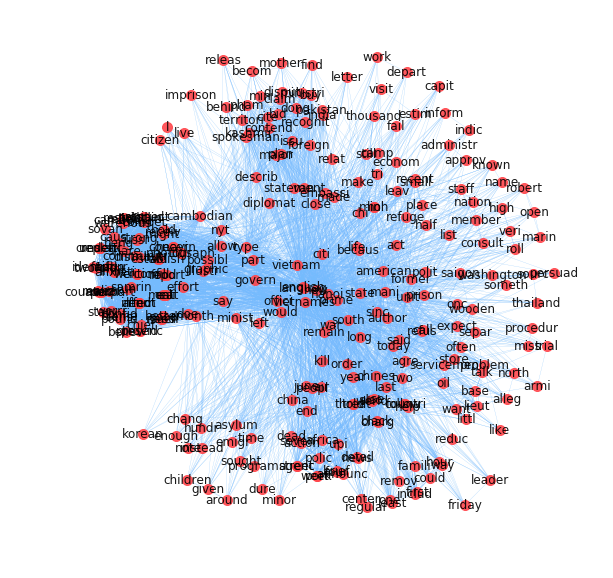

In [91]:
layout = nx.spring_layout(gWord, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gWord, ax = ax, pos = layout, labels = {n:n for n in gWord.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [92]:
minWeight = 2
gWord.remove_edges_from([(n1, n2) for n1, n2, d in gWord.edges(data = True) if d['weight'] <= minWeight])
gWord.remove_nodes_from(list(nx.isolates(gWord))) #since we are changing the graph list() evuluates the isolates first
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 106
Number of edges: 1028
Average degree:  19.3962


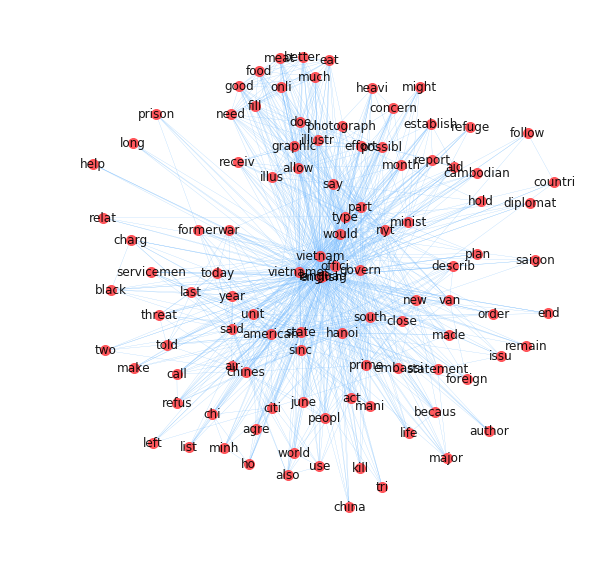

In [93]:
layout = nx.spring_layout(gWord, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gWord, ax = ax, pos = layout, labels = {n:n for n in gWord.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying